In [29]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

In [100]:
from sklearn.base import BaseEstimator, TransformerMixin
import scipy
from math import sqrt
from collections import Counter

# sklearnのTransformerにしたので、fit_tramsformを呼ぶと外れ値の閾値を返す
class OutlyerModel(BaseEstimator, TransformerMixin):

    def __init__(self, p = 0.99, search_list = list(range(1, 11)), parcentile = 0):
        self._p = p
        self._search_list = search_list
        self._parcentile = parcentile
        self._component_selection_method = self.simple
        if parcentile > 0:
            self._component_selection_method = self.parcentile

    def gmm_search(self, x):
        search_list = self._search_list
        # 最小のBICのクラス数を三分探索をする
        # https://qiita.com/DaikiSuyama/items/84df26daad11cf7da453
        sarch_list_size = len(search_list)
        left = 0
        right = sarch_list_size - 1

        gmms = [None] * sarch_list_size
        bics = [None] * sarch_list_size

        self.gmm_fit_count_ = 0
        # 各インデックスのクラス数のBICを計算、もしくはキャッシュから得る
        def get_bic(index):
            if (bics[index] is None):
                gmm = GaussianMixture(n_components=search_list[index], reg_covar=1.0e-3)
                gmm = gmm.fit(x)
                bic = gmm.bic(x)
                gmms[index] = gmm
                bics[index] = bic
                self.gmm_fit_count_ += 1
                return bic
            return bics[index]

        # right=left,left+1,left+2のいずれかになれば探索終了
        while(left + 2 < right):
            centor1 = left + (right - left) // 3
            centor2 = right - (right - left) // 3

            # 3分点を計算する
            centor1_bic = get_bic(centor1)
            centor2_bic = get_bic(centor2)
            if centor1_bic < centor2_bic:
                right = centor2
            else:
                left = centor1

        # left-rightの間の最小値が最小値
        min_bic = float('inf')
        min_index = -1
        for i in range(left, right+1):
            bic = get_bic(i)
            if bic < min_bic:
                min_bic = bic
                min_index = i
        return min_index, bics, gmms

    def fit(self, X):
        return self

    def predict(self, X):
        x = X.reshape((-1,1))
        return self.gmm_.predict(x)
    
    def simple(self, x):
        means = self.gmm_.means_
        return np.argmax(means), np.argmin(means)

    def parcentile(self, x):
        # parcentileで指定されたパーセンタイルを含むcomponentの中で最大と最小で外れ値を判断する
        # selectsに指定されたパーセンタイルになるまでindexを集める
        components = self.gmm_.predict(x)
        size = len(components)
        counter = Counter(components)
        sum = 0
        selects = []
        for i, count in counter.most_common():
            selects.append(i)
            sum += count
            if sum / size > (1 - self._parcentile):
                break
        
        # selectsに集まった平均値の中から最大と最小の平均値のindexを得る
        max_mean = -float('inf')
        min_mean = float('inf')
        max_index = 0
        min_index = 0
        means = self.gmm_.means_
        for i in selects:
            if max_mean < means[i]:
                max_index = i
                max_mean = means[i]
            if means[i] < min_mean:
                min_index = i
                min_mean = means[i]
        return max_index, min_index

    def transform(self, X):
        # 最良のbicが得られるgmmを探索する
        x = X.reshape((-1,1))
        min_index, bics, gmms = self.gmm_search(x)
        self.min_index_ = min_index
        self.bics_ = bics
        self.gmms_ = gmms
        self.gmm_ = gmms[min_index]
        self.n_components_ = self._search_list[min_index]

        # 推定結果のうち、最大の物と最小の物の分布でホテリング法を用いて99%閾値を求める
        gmm = self.gmm_
        #index_max = np.argmax(gmm.means_)
        #index_min = np.argmin(gmm.means_)
        index_max, index_min = self._component_selection_method(x)
        mu = gmm.means_[index_max]
        s2 = gmm.covariances_[index_max]
        thr = scipy.stats.chi2.ppf(self._p, 1)
        thr_high = (2 * mu + sqrt((mu * -2) ** 2 - 4 * (mu ** 2 - thr * s2))) / 2
        mu = gmm.means_[index_min]
        s2 = gmm.covariances_[index_min]
        thr_low = (2 * mu - sqrt((mu * -2) ** 2 - 4 * (mu ** 2 - thr * s2))) / 2
        return thr_high, thr_low


(array([734., 188., 194., 268., 262., 293.,  42.,  14.,   3.,   2.]),
 array([ 0. ,  1.2,  2.4,  3.6,  4.8,  6. ,  7.2,  8.4,  9.6, 10.8, 12. ]),
 <BarContainer object of 10 artists>)

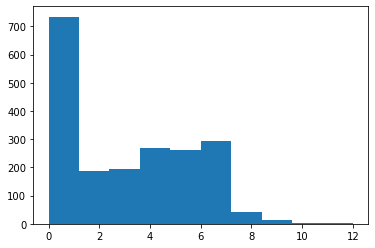

In [53]:
y = np.random.poisson(lam=1.0, size=1000)
y = np.append(y, np.random.poisson(lam=2.0, size=1000) + 3)
y[1999] = 12
plt.hist(y)

In [101]:
outlyer = OutlyerModel()
outlyer.fit_transform(y)

(array([11.90107237]), array([-0.08145487]))

In [109]:
outlyer = OutlyerModel(parcentile=0.001)
outlyer.fit_transform(y)

(array([11.90107237]), array([-0.08145487]))

In [75]:
outlyer.predict(y)

array([7, 4, 7, ..., 8, 1, 9])

In [79]:
display(outlyer.min_index_)
display(outlyer.bics_)
outlyer.gmm_fit_count_

9

[None,
 None,
 None,
 7545.717418452366,
 None,
 4626.5182068908625,
 3175.6803952283176,
 331.8185748984322,
 -1120.0173963210564,
 -1336.9683718593683]

6